In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from scipy import stats

from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, Birch, DBSCAN, KMeans, MiniBatchKMeans, MeanShift, OPTICS, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV

# Data Exploration

In [4]:
data = pd.read_csv("../datasets/help.csv")

In [5]:
data.shape

(167, 10)

In [10]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [9]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [12]:
country = data[["country"]]
data = data.drop("country", axis=1)

<AxesSubplot:>

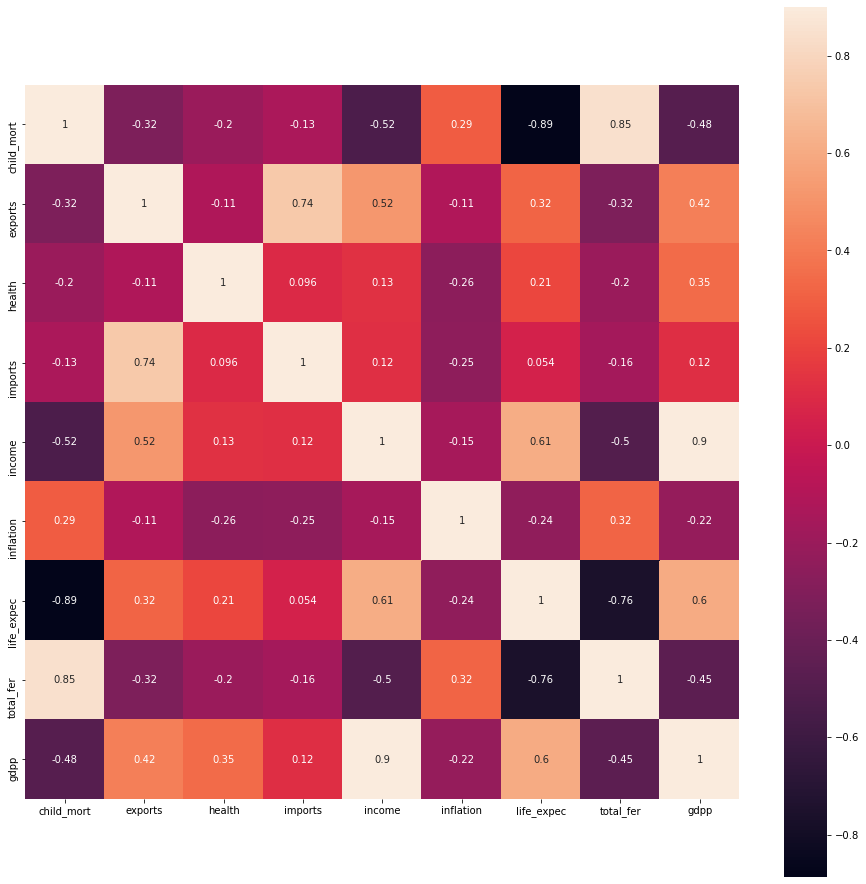

In [14]:
plt.subplots(figsize=(16,16))
sns.heatmap(data.corr(), vmax=0.9, square=True, annot=True)

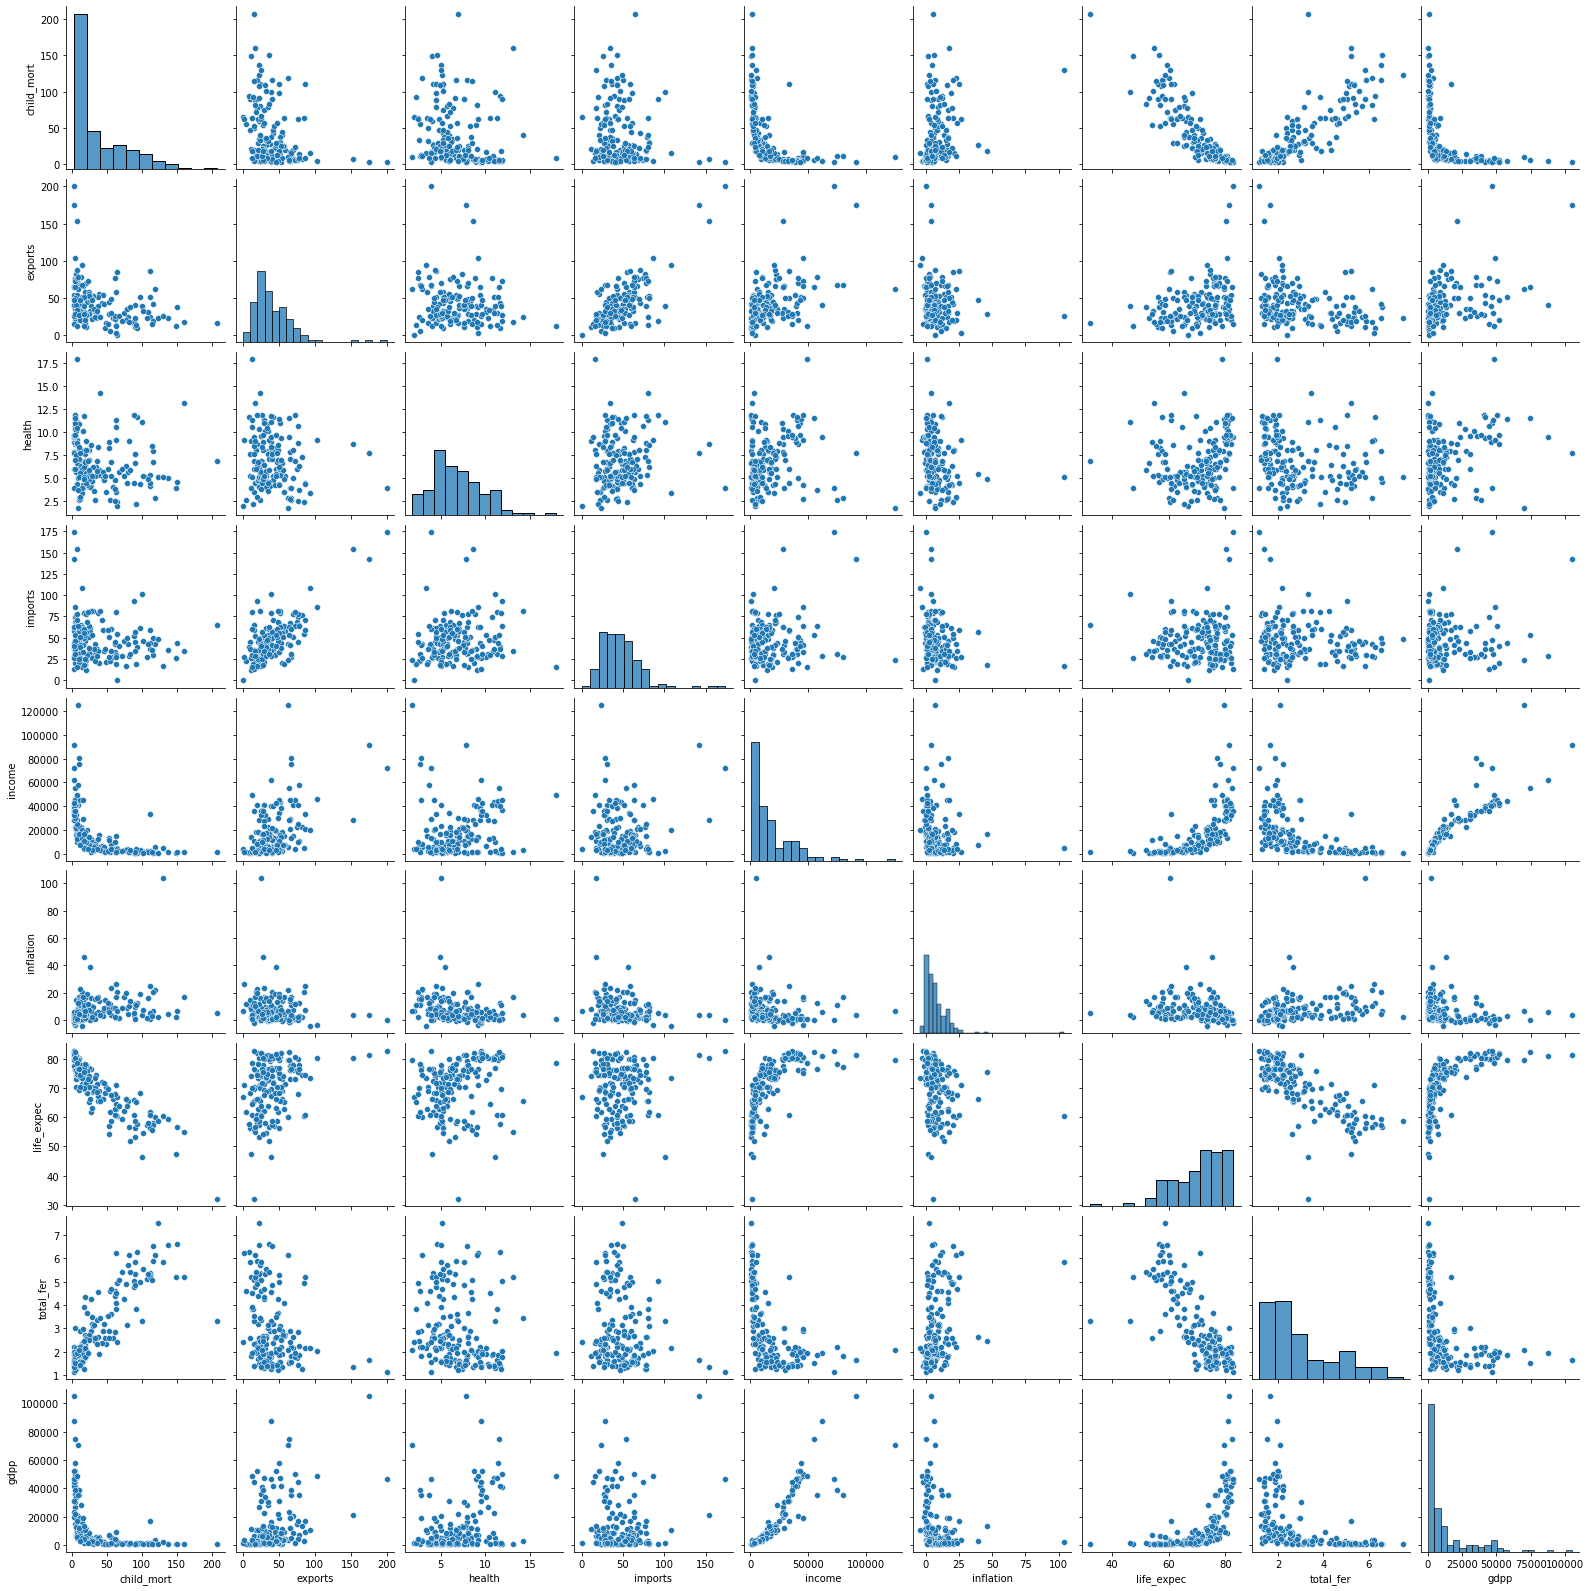

In [15]:
sns.pairplot(data)

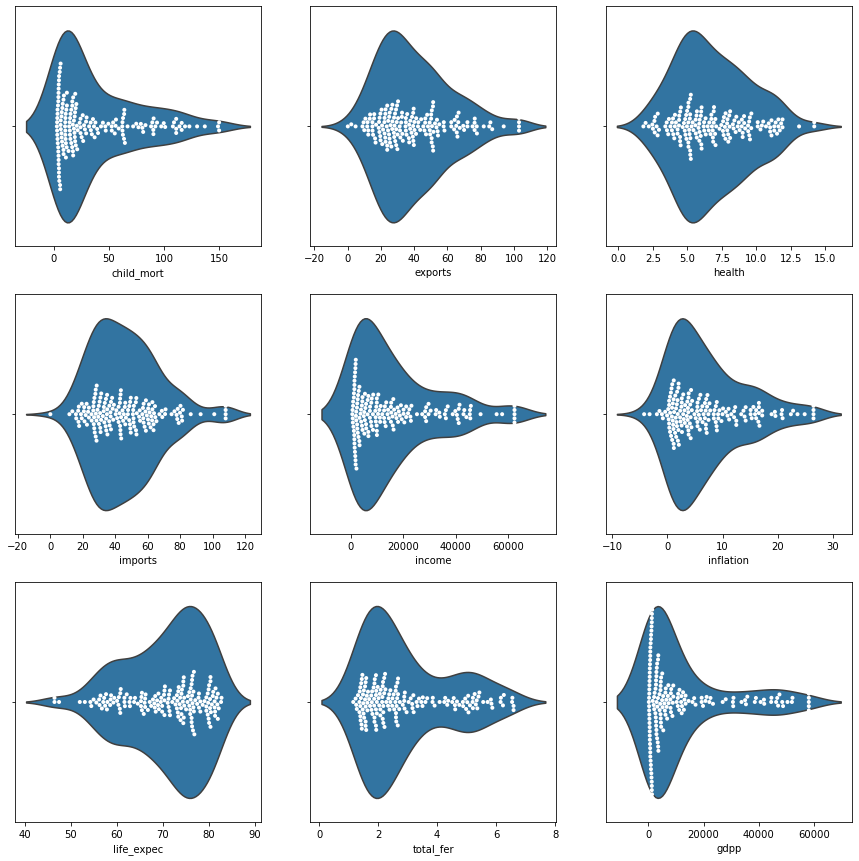

In [154]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
for i in range(9):
    sns.violinplot(ax = axes[i // 3][i % 3], x=data.columns[i], data=data, inner=None)
    sns.swarmplot(ax = axes[i // 3][i % 3], x=data.columns[i], data=data, color="white", edgecolor="gray", size=4)

In [37]:
# Check statistically for outliers through z score
zscores = data.apply(stats.zscore).abs()
zscores[zscores < 3] = 0
zscores[zscores >= 3] = 1
zscores.sum(axis=0)

child_mort    2.0
exports       3.0
health        1.0
imports       3.0
income        4.0
inflation     2.0
life_expec    1.0
total_fer     1.0
gdpp          4.0
dtype: float64

In [38]:
# There are only a few outliers; what happens if we simply remove them?
data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].shape
# A little bit less than 10% of all entries are removed, which is not ideal.

(153, 9)

In [44]:
# Instead, what we can do is to cap the data, or replace outliers by non-outlier max/min.
for i in data.columns:
    no_outliers = data[i][(np.abs(stats.zscore(data[i])) < 3)]
    data[i].clip(min(no_outliers), max(no_outliers))

In [45]:
# Check statistically for outliers through z score again
zscores = data.apply(stats.zscore).abs()
zscores[zscores < 3] = 0
zscores[zscores >= 3] = 1
zscores.sum(axis=0)
# Perfect!

child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

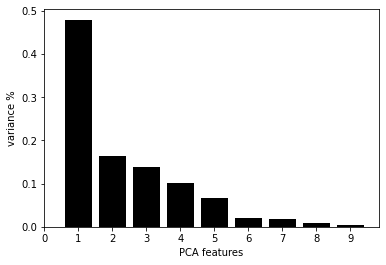

In [60]:
from sklearn.decomposition import PCA
# How well does PCA help us?
scaled = StandardScaler().fit_transform(data)
pca = PCA()
ve = pca.fit_transform(scaled)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_ + 1))
PCA_components = pd.DataFrame(ve)

# It seems as though the dropoff happens after the first feature, and then a smaller one after five.
# For now, we can avoid using PCA, but we can come back to it later.

# Model Selection

In [82]:
from sklearn.metrics.pairwise import cosine_similarity
def plot_clusters(results):
    pca = PCA(2)
    X_PCA = pca.fit_transform(data)
    sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], hue=results)
    plt.show()

def plot_columns(x, y, results):
    sns.scatterplot(x=data[x], y=data[y], hue=results)
    plt.show()

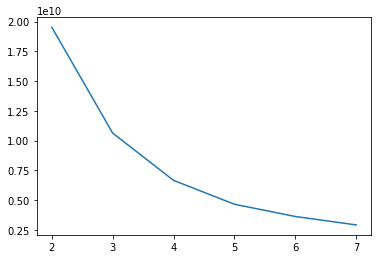

In [74]:
cost = [KMeans(i).fit(data).inertia_ for i in range(2, 8)]
sns.lineplot(x=range(2, 8), y=cost)
# Best clustering seems to be around 4 or 5 clusters for KMeans.
kmeans = KMeans(4).fit(data)

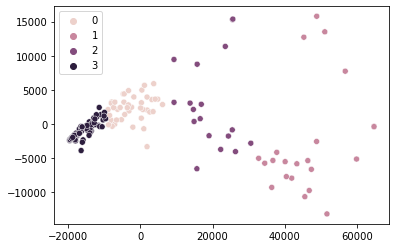

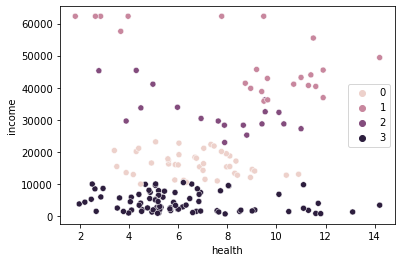

In [84]:
plot_clusters(kmeans.labels_)
plot_columns("health", "income", kmeans.labels_)

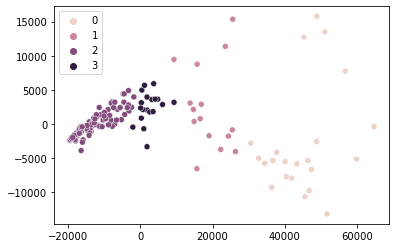

In [104]:
agg = AgglomerativeClustering(n_clusters=4).fit(data)
plot_clusters(agg.labels_)

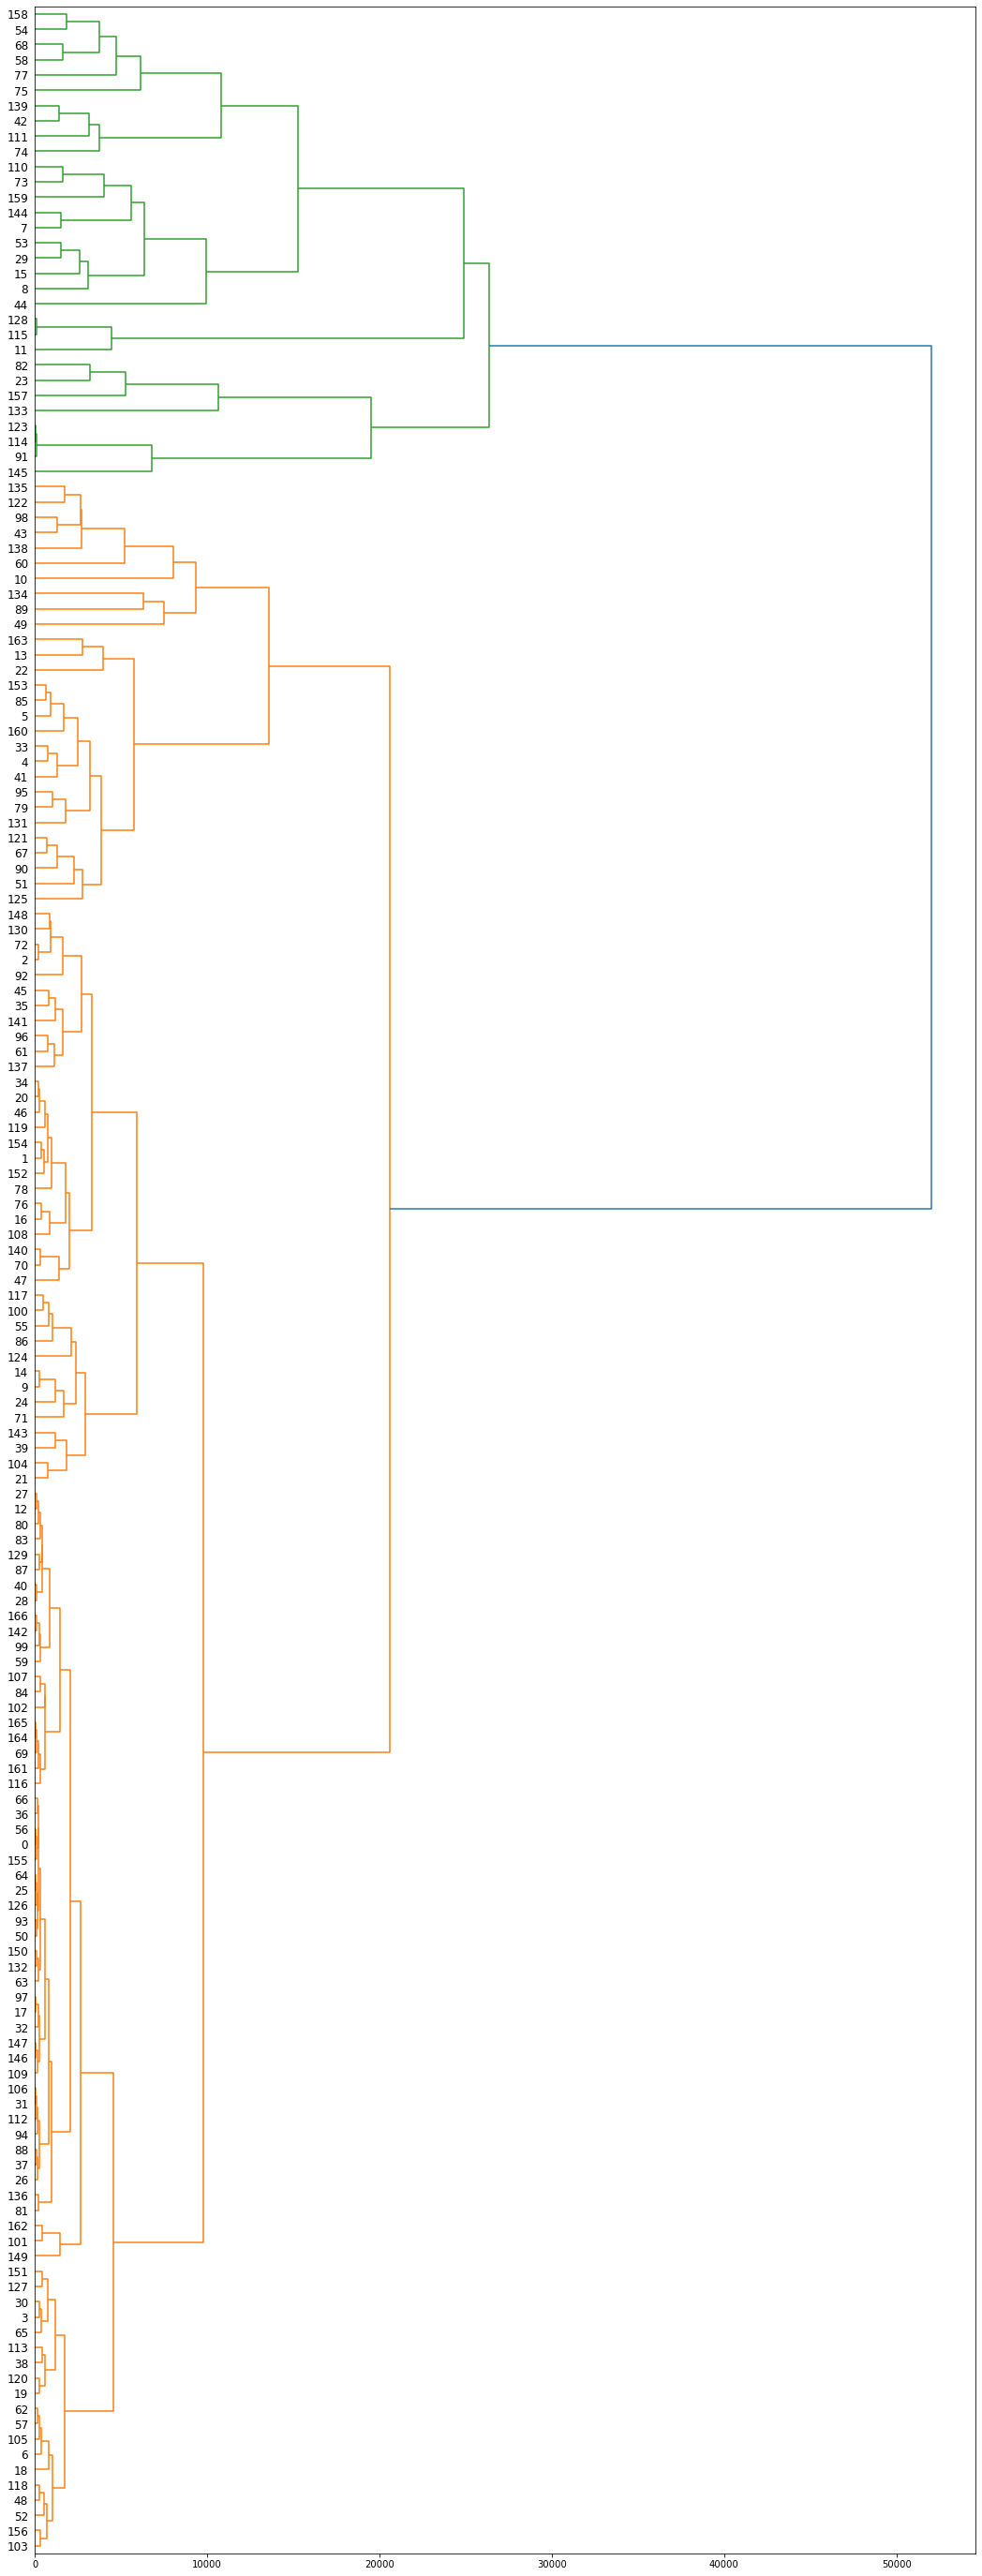

In [107]:
from scipy.cluster import hierarchy
plt.figure(figsize=(18, 50))
hierarchy.dendrogram(hierarchy.linkage(data, "average"), leaf_rotation=0, leaf_font_size=12, orientation='right')
plt.show()

In [123]:
ap = AffinityPropagation(damping=.9)
ap.fit_predict(data)
ap.labels_
# way too many clusters, and changing the damping value doesn't fix much.

/home/daniel/miniconda3/envs/kaggle/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


array([7, 2, 5, 2, 0, 0, 2, 9, 9, 5, 1, 6, 7, 0, 5, 3, 2, 7, 2, 2, 2, 5,
       5, 4, 5, 7, 7, 7, 7, 3, 2, 7, 7, 0, 2, 5, 7, 7, 2, 5, 7, 0, 8, 1,
       9, 5, 2, 2, 2, 1, 7, 0, 2, 3, 3, 5, 7, 2, 3, 7, 8, 5, 2, 7, 7, 2,
       7, 0, 3, 7, 2, 5, 5, 9, 8, 8, 2, 3, 2, 0, 7, 7, 4, 7, 7, 0, 5, 7,
       7, 1, 0, 9, 5, 7, 7, 0, 5, 7, 1, 7, 5, 7, 7, 2, 5, 2, 7, 7, 2, 7,
       9, 8, 7, 2, 9, 6, 7, 5, 2, 2, 2, 0, 1, 9, 5, 0, 7, 2, 6, 7, 5, 0,
       7, 4, 1, 1, 7, 5, 1, 8, 2, 2, 7, 5, 9, 9, 7, 7, 5, 7, 7, 2, 2, 0,
       2, 7, 2, 4, 3, 9, 0, 7, 7, 0, 7, 7, 7])

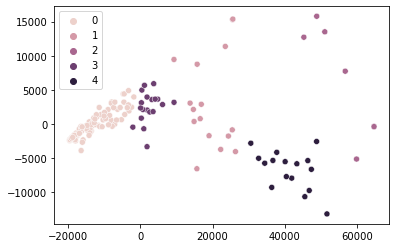

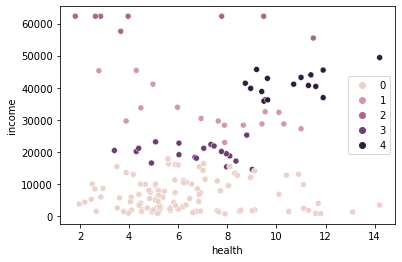

In [126]:
b = Birch(threshold=0.1, n_clusters=5)
b.fit_predict(data)
plot_clusters(b.labels_)
plot_columns("health", "income", b.labels_)

In [135]:
db = DBSCAN(eps=.33, min_samples=5)
db.fit_predict(data)
db.labels_
# doesn't seem to converge.

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

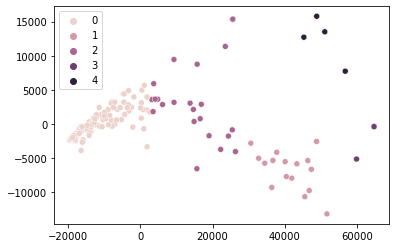

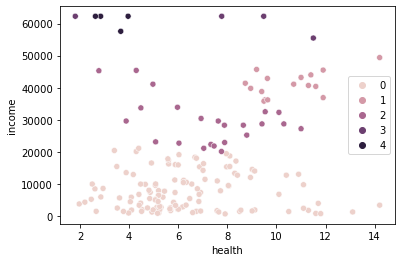

In [137]:
ms = MeanShift()
ms.fit_predict(data)
plot_clusters(ms.labels_)
plot_columns("health", "income", ms.labels_)

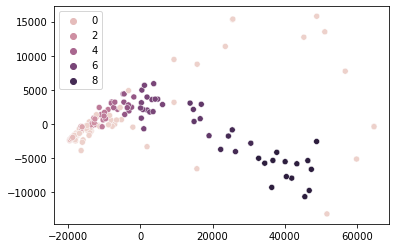

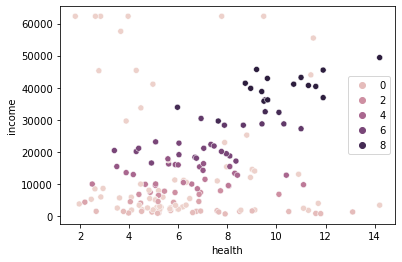

In [140]:
op = OPTICS()
op.fit_predict(data)
plot_clusters(op.labels_)
plot_columns("health", "income", op.labels_)

# this result isn't very reasonable.

/home/daniel/miniconda3/envs/kaggle/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/daniel/miniconda3/envs/kaggle/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  est = KMeans(


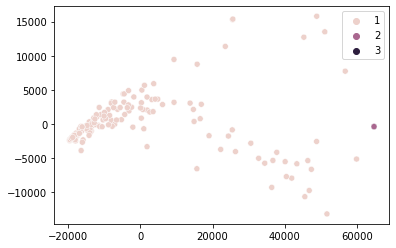

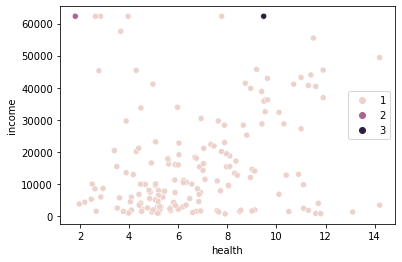

In [141]:
sc = SpectralClustering(n_clusters=4)
sc.fit_predict(data)
plot_clusters(sc.labels_)
plot_columns("health", "income", sc.labels_)

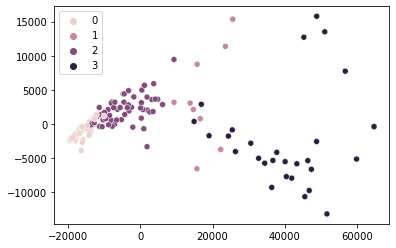

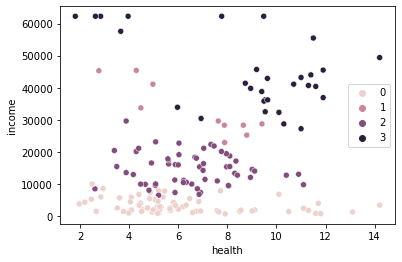

In [145]:
gm = GaussianMixture(n_components=4)
labels = gm.fit_predict(data)
plot_clusters(labels)
plot_columns("health", "income", labels)

/home/daniel/miniconda3/envs/kaggle/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


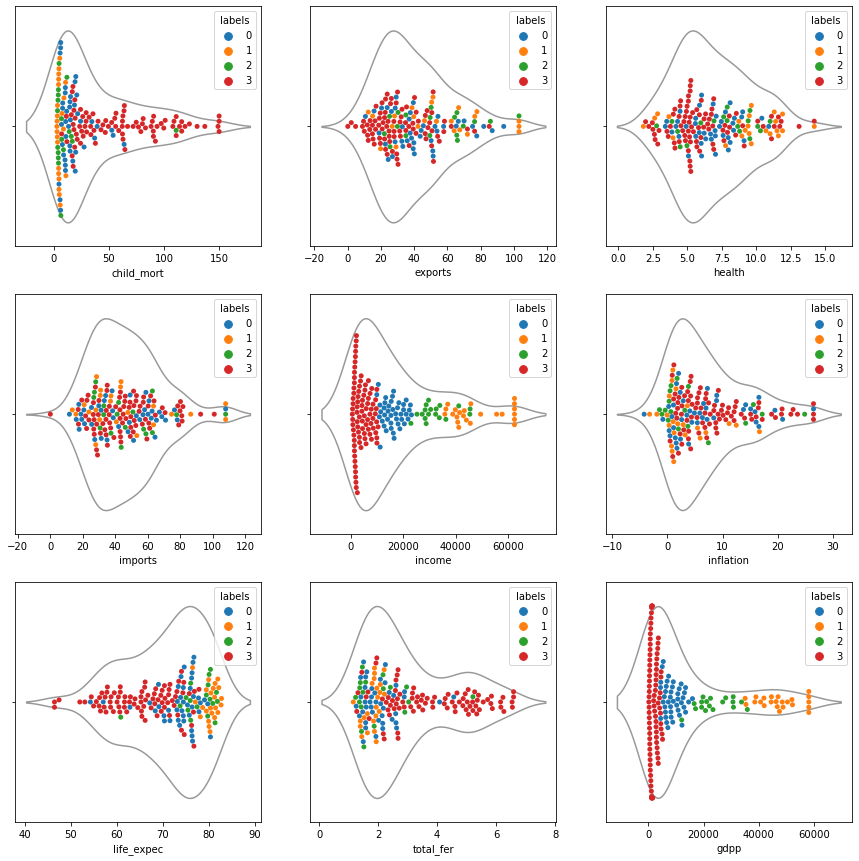

In [181]:
# We can look at how each variable behaved in the regular kmeans algorithm using a swarmplot:
labeled = data
data[["labels"]] = list(kmeans.labels_)
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)

for i in range(9):
    sns.violinplot(ax = axes[i // 3][i % 3], x=data.columns[i], data=data, inner=None, color="white")
    sns.swarmplot(ax = axes[i // 3][i % 3], x=data[data.columns[i]], y=[""]*len(data["labels"]), hue=data["labels"])
    
# Out of all of the variables, only GDP/income really had that much of a large impact on the clustering.

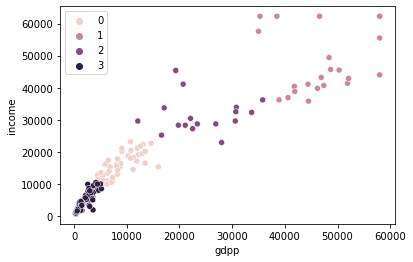

In [182]:
plot_columns("gdpp", "income", kmeans.labels_)